In [1]:
import os
import array
import time
import struct
import fnmatch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import array
import scipy.io as sio
import Amys_Library as al
from sklearn.decomposition.pca import PCA
import networkx as nx
from matplotlib import patches
from sklearn import preprocessing

In [2]:
directory = '../Costas_Ca_project_Sim4/Single_cell_data'

calcium = np.zeros([511, 600000])
i = 0 

for dirpath, dirs, files in os.walk(directory):
    for filename in fnmatch.filter(files, '*ca.dat'):
        if (i == 40):
            i = i+1
        calcium[i] = np.fromfile(os.path.join(dirpath, filename), dtype = np.float32)
        i = i + 1

In [3]:
%time
%matplotlib inline

#from IPython.parallel import Client
#c = Client()
#v = c[:]

#directory where all the .bin simulation files are located
directory = '../Costas_Ca_project_Sim4/Single_cell_data'
a = array.array('f')


for dirpath, dirs, files in os.walk(directory):
    for filename in fnmatch.filter(files, '*ca.dat'):
        a.fromfile(open(os.path.join(dirpath, filename), 'rb'), 
                   os.path.getsize(os.path.join(dirpath, filename))/a.itemsize)
    
    
calcium = np.asarray(a)

#calcium.shape = [2022, 59999];


#directory = '../Costas_Ca_project/Vm'
#a = array.array('f')


#for dirpath, dirs, files in os.walk(directory):
#    for filename in fnmatch.filter(files, '*.bin'):
#        a.fromfile(open(os.path.join(dirpath, filename), 'rb'), 
#                   os.path.getsize(os.path.join(dirpath, filename))/a.itemsize)   
       
#voltage = np.asarray(a)
#voltage.shape = [2022, 59999]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [3]:
#sample simulation in a z-stack

xyz = np.asarray(np.loadtxt('../Costas_Ca_project_Sim3/Locations/pos.csv', delimiter=','))
#weight = np.load('../Costas_Ca_project_Sim3/Connectivity/loc_con.npz')

data = np.load('../Costas_Ca_project_Sim4/Connectivity/loc_con.npz')
loc_con = sp.sparse.csr_matrix((data['data'], data['indices'], data['indptr']), shape=data['shape'])
weight = loc_con.todense()


#change the zlims to get more data... ALL the data is 2022 x 599999... 
xyz_s = np.asarray(np.where((xyz[:,2] > 1100) & (xyz[:,2] < 1150) & (calcium[:,10000] > 0))).flatten()

calcium_s = calcium[xyz_s]
#voltage_s = voltage[xyz_s]
pos = xyz[xyz_s]
weight = weight[xyz_s]
weight = weight[:,xyz_s]
print weight.shape

(73, 73)


In [4]:
GCaMP = al.image_sample(calcium_s, al.p_mask(pos))

/Library/Python/2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


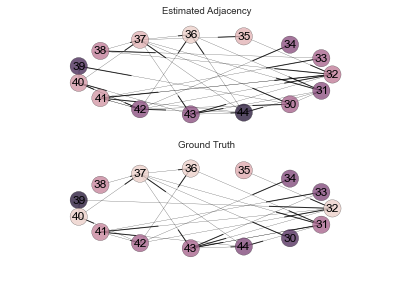

In [438]:
# plot graphs!

import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid')

# sns.cubehelix_palette(8, start = .5, rot = -.75, as_cmap = True)
plt.figure(1)
plt.subplot(211)
plt.title('Estimated Adjacency')
nx.draw_circular(A, width = .25, alpha = .8, node_size = 300, node_color = deg, cmap = sns.cubehelix_palette(8, as_cmap = True), with_labels = True)
plt.subplot(212)
plt.title('Ground Truth')
nx.draw_circular(B, width = .25, alpha = .8, node_size = 300, node_color = deg1, cmap = sns.cubehelix_palette(8, as_cmap = True), with_labels = True)
plt.show()

In [452]:
#compute regression permutations
#currently broken.....

from IPython.parallel import Client
c = Client()
v = c[:]
c.ids

perm = []
for i in xrange(5, 20):
    for x in range(10):
        perm.append(np.random.random_integers(1,25,i))

print perm
        
        
res = v.map(al.granger_a(_), _ = perm).get()

[array([20,  5,  6, 21, 23]), array([17, 16,  6, 18, 15]), array([11, 18,  9, 18, 12]), array([18,  6,  1, 19, 20]), array([ 2, 15, 21,  8,  6]), array([24, 11, 23,  8, 25]), array([18, 17, 11,  1, 11]), array([ 5, 24, 11, 13,  8]), array([12, 11, 24,  4, 19]), array([20, 10, 13, 13, 17]), array([24, 24, 25, 22,  4,  9]), array([19,  6, 21,  4, 16,  5]), array([ 7, 19, 22, 25, 11, 24]), array([18,  7, 20, 25, 23, 12]), array([ 9,  5, 16, 10, 13, 25]), array([ 8, 17, 23,  4, 15, 13]), array([18, 23, 15, 25,  7, 13]), array([16,  2, 23,  4, 25, 11]), array([16, 13, 15,  6, 21,  6]), array([ 4, 15, 13,  7, 22, 20]), array([13,  7,  8, 10, 12,  3, 16]), array([12,  8, 17, 11,  2,  7, 21]), array([19, 21, 24, 22, 17,  6, 22]), array([13, 22, 15, 25, 17, 11,  3]), array([ 1, 25,  1,  5, 19, 22,  3]), array([ 6,  6, 22, 11, 16,  9, 14]), array([ 4, 20,  1, 12, 22,  2,  8]), array([11,  7, 22, 18,  8,  9,  7]), array([16,  6, 12, 23, 11, 14, 12]), array([21, 16, 12,  2, 12,  2, 13]), array([ 4

IndexError: arrays used as indices must be of integer (or boolean) type

In [5]:
c_best = []
n_best = []

for i in range(weight.shape[0]):
    n_temp, c_temp = al.fnnd(GCaMP[i], dt = .1)
    c_best.append(c_temp)
    n_best.append(n_temp)
    
c_best = np.array(c_best)
c_best.shape = GCaMP.shape

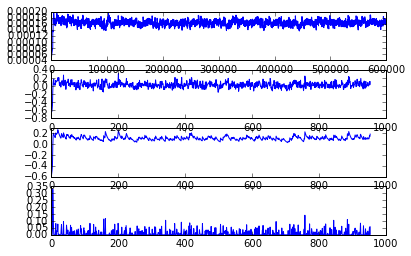

In [49]:
#this creates figure 1
plt.subplot(411)
plt.plot(calcium_s[0])
plt.subplot(412)
plt.plot(GCaMP[0])
plt.subplot(413)
plt.plot(c_best[0])
plt.subplot(414)
plt.plot(n_best[0])

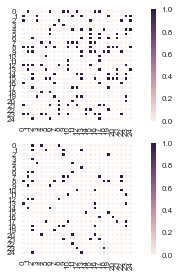

In [473]:
%matplotlib osx

plt.figure(3)
plt.subplot(211)
sns.heatmap(b_bin, square = True)
plt.subplot(212)
sns.heatmap(weight_bin, square = True)
plt.show()

In [474]:
#graphs for granger

A = nx.DiGraph()
B = nx.DiGraph()

#add nodes to teh digraph
for i in xrange(0,25,1):
    A.add_node(i)
    for j in xrange(0,25,1):
        if (b_bin[i, j] != 0):
            A.add_edge(i, j)
            
for i in xrange(0,25,1):
    B.add_node(i)
    for j in xrange(0,25,1):
        if (weight_bin[i, j] != 0):
            B.add_edge(i, j)
            
#color edges by their degree            
degtemp = A.degree()
degtemp1 = B.degree()
deg = []
deg1 = []
for i in xrange(0,25,1):
    deg.append(degtemp[i])
    deg1.append(degtemp1[i])


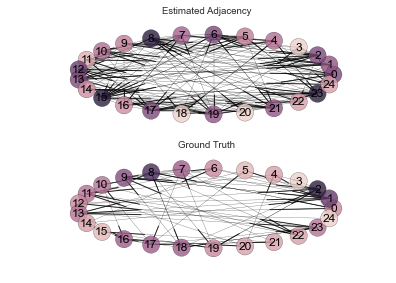

In [475]:
plt.figure(1)
plt.subplot(211)
plt.title('Estimated Adjacency')
nx.draw_circular(A, width = .25, alpha = .8, node_size = 300, node_color = deg, cmap = sns.cubehelix_palette(8, as_cmap = True), with_labels = True)
plt.subplot(212)
plt.title('Ground Truth')
nx.draw_circular(B, width = .25, alpha = .8, node_size = 300, node_color = deg1, cmap = sns.cubehelix_palette(8, as_cmap = True), with_labels = True)
plt.show()

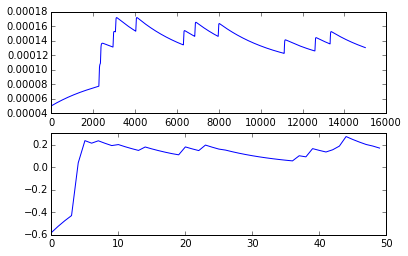

In [247]:
plt.figure()
plt.subplot(211)
plt.plot(calcium[0][0:15000])
plt.subplot(212)
plt.plot(c_best[0][0:50])


In [18]:
 
score = al.lasso_GC(preprocessing.scale(c_best[:, 0:160], axis = 1), 120, 20)

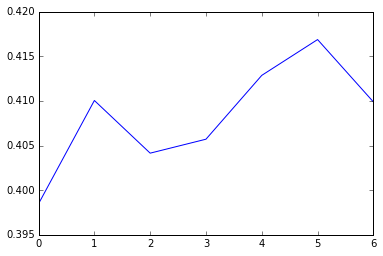

In [15]:
score_mat = []

for item in score:
    score_mat.append(al.dice(item > 0, weight >0))
    
plt.plot(score_mat)

In [145]:
a = np.sum(np.logical_and(weight[0:100, 0:100] == 0, score < 0.3 ))

b = np.sum(weight[0:100, 0:100] == 0)

print a, b

4901 6830


In [14]:
%matplotlib inline

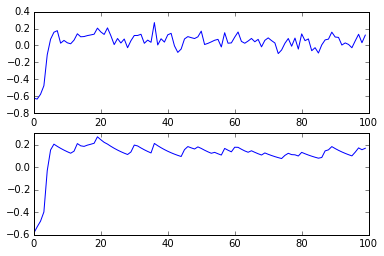

In [149]:
plt.figure()
plt.subplot(211)
plt.plot(GCaMP[0][0:100])
plt.subplot(212)
plt.plot(c_best[0][0:100])

In [20]:
print al.dice(score > 0, weight > 0)

0.406976744186


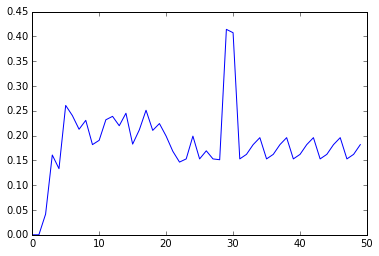

In [93]:
plt.plot(dice1)

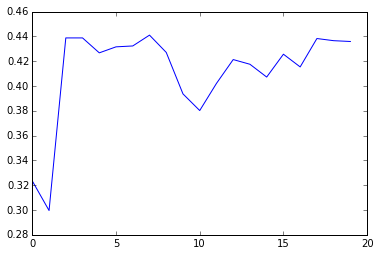

In [138]:
plt.plot(dice2)

In [134]:
dice2[14]

0.41739130434782606

In [136]:
reload(al)

<module 'Amys_Library' from 'Amys_Library.py'>

In [152]:
np.savetxt('Sim2_GCaMP', GCaMP)

In [160]:
np.savetxt('score', score > 0)